In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd 
pd.set_option('display.max_rows', 10)
import scipy
from sklearn import metrics
import time
from scipy.stats import gaussian_kde

In [5]:
def rescale_data(data, original):
    """
    rescale an array according to another array (original)
    """
    data_array = np.array(data)
    scaled_data = np.interp(
                            data_array, 
                            (data_array.min(), data_array.max()), 
                            (min(original), max(original)) 
                            )
    return list(scaled_data)
def permutate_value(value, deviate):
    """
    permutate a value randomly in a scale of deviate variable
    """
    # generate a random number within the range:
    factor = np.random.uniform(-deviate, deviate)
    # permutate the FEP value to generate a 'slightly off' prediction
    random_pred = value - factor

    return random_pred

In [6]:
# read in dataset
dataset = pd.read_csv("dataset_source.txt", sep=";", usecols=[0,3,5], names=["cpd", "exp", "fep"])[1:]
dataset

,cpd,exp,fep
1,mobley_1017962,-2.49,-3.30
2,mobley_1019269,-4.72,-3.23
3,mobley_1034539,-3.04,-1.08
4,mobley_1036761,-4.59,-3.95
5,mobley_1046331,-3.82,-5.44
...,...,...,...
638,mobley_9913368,-0.78,1.02
639,mobley_9942801,-0.95,-0.57
640,mobley_994483,-0.74,0.49
641,mobley_9974966,-1.21,0.14


In [9]:
# take arrays of the data:
original_exp = dataset["exp"].astype(float).values
original = dataset["fep"].astype(float).values

# generate a worse prediction of the experimental values by transforming the fep values with noise:
worse = [ permutate_value(value, 8) for value in original ]
worse = rescale_data(worse, original)

# generate a bad prediction of the experimental values by transforming the fep values with noise:
worst = [ permutate_value(value, 20) for value in original ]
worst = rescale_data(worst, original)

In [45]:
# set up datasets for looping:
fep_values_collections = [original, worse, worst]
collection_counts = [0, 1, 2]
num_correctors = 10

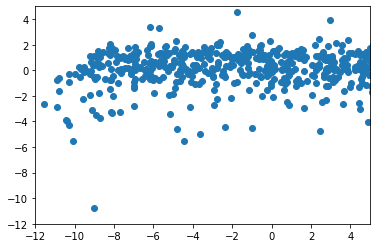

0.27714936245306887
Corrected: 0.5522591517192583


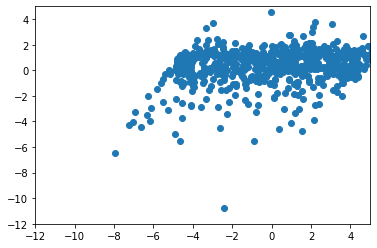

0.2931050873051135
Corrected: 0.7958923892985276


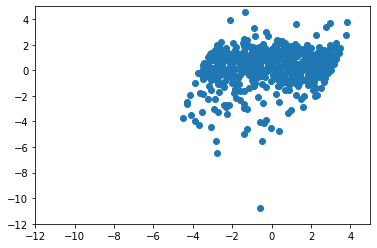

0.1990195267259034
Corrected: 0.8698100734021121


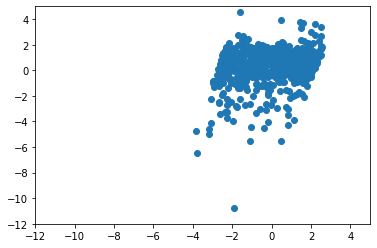

0.24299464808230678
Corrected: 0.9034072621632218


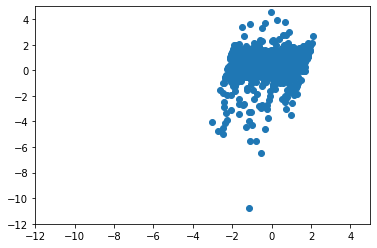

0.2299784775931171
Corrected: 0.9173437323132908


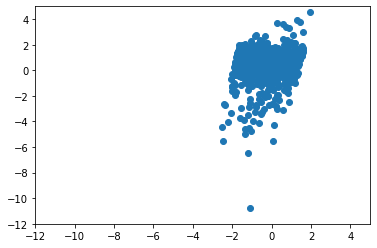

0.21953419600516788
Corrected: 0.9245163709964168


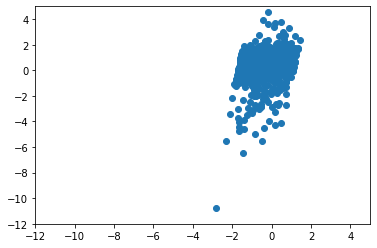

0.29662891152542614
Corrected: 0.9329239819891038


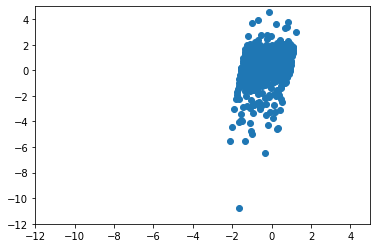

0.2714250732959862
Corrected: 0.9335675117593862


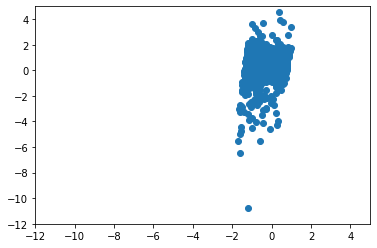

0.26467915237581024
Corrected: 0.9332534292747525


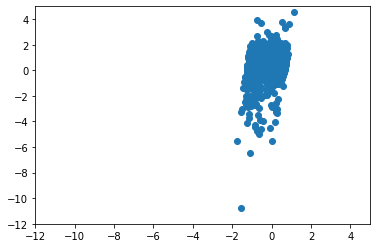

0.279890743569468
Corrected: 0.9370680467325415
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


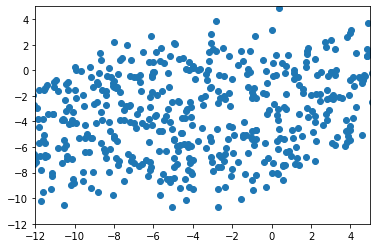

0.5545865029246427
Corrected: 0.5549935000850914


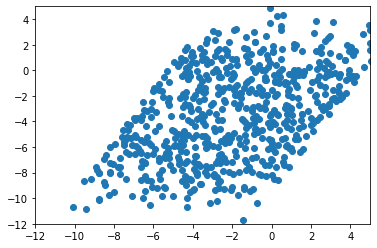

0.5018970023870901
Corrected: 0.7031869097037936


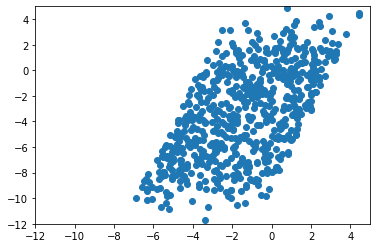

0.5786646951198181
Corrected: 0.7501223127436704


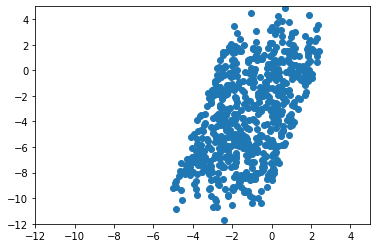

0.5073453306146964
Corrected: 0.7289296661515721


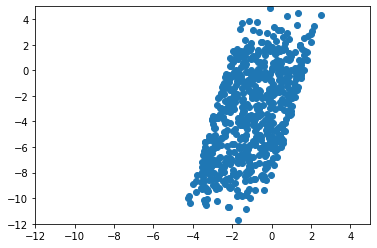

0.5368383820368314
Corrected: 0.7205867224079756


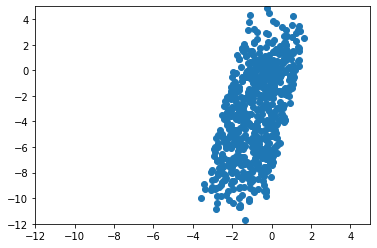

0.5075010905662679
Corrected: 0.7141713496283807


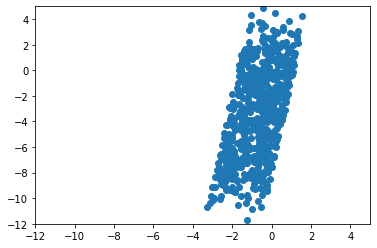

0.5143365943006529
Corrected: 0.7038222156445435


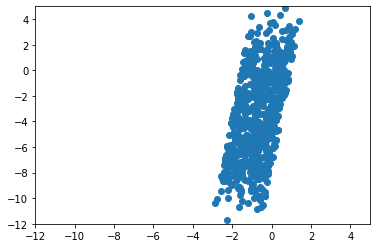

0.5373896581197655
Corrected: 0.7032243536602116


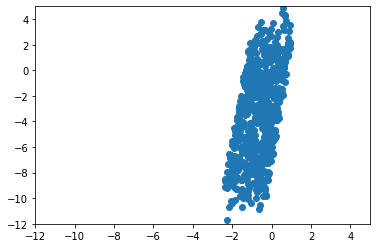

0.5347237322769806
Corrected: 0.6996202211025846


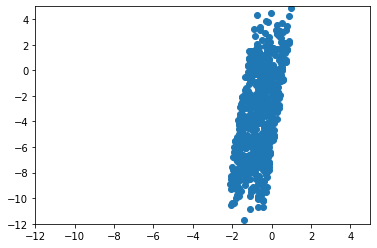

0.5202765794400139
Corrected: 0.6921321201409584
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


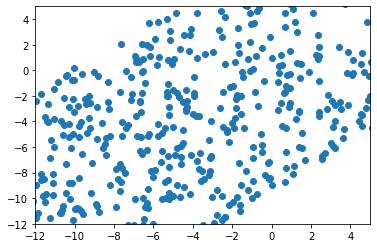

0.7067984339161398
Corrected: 0.5483976983258684


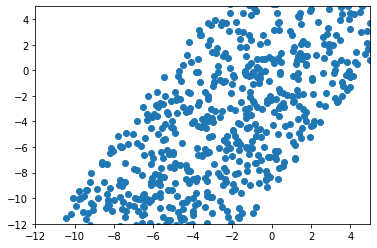

0.7223213722120431
Corrected: 0.5733093117790575


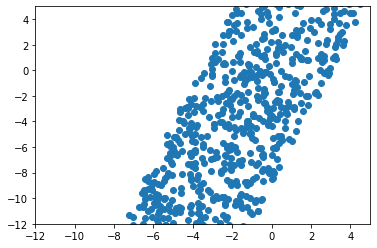

0.7050089708921565
Corrected: 0.5131004923700758


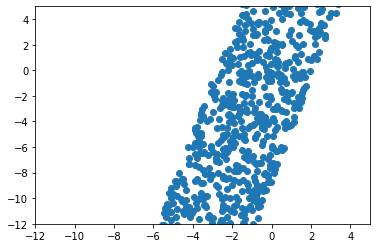

0.6764829312860289
Corrected: 0.45419935998748767


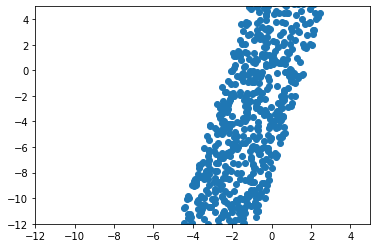

0.6966905736440933
Corrected: 0.43372513076292907


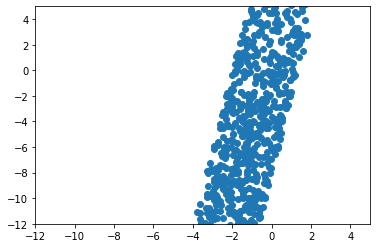

0.6724227494286613
Corrected: 0.39267168530616264


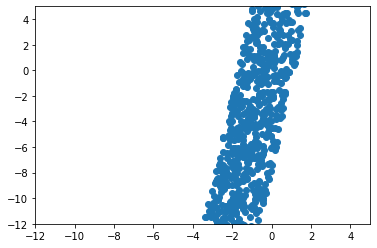

0.714654472147844
Corrected: 0.38489227444958585


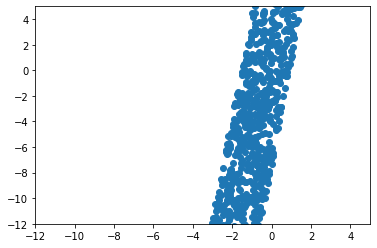

0.7021653585854936
Corrected: 0.37163630451139784


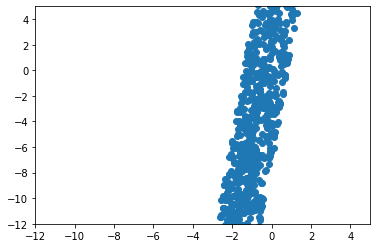

0.7128511167877168
Corrected: 0.3669837203243157


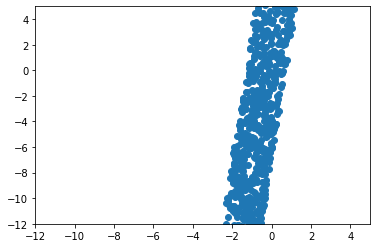

0.694933471521252
Corrected: 0.3525646098219588
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


In [63]:
# make base plot with annotations:
# fig, axs = plt.subplots(len(collection_counts), 4,constrained_layout=True)
# fig.set_size_inches(10, 6.5)

for fep_values, collection_count in zip(fep_values_collections, collection_counts):
    # for this FEP vs EXP dataset (so fep, worse or worst):
    # compute statistics:
    offsets = np.array(fep_values) - np.array(original_exp)

    fep_r = scipy.stats.pearsonr(dataset["exp"].astype(float).values, fep_values)[0]
    fep_mue = metrics.mean_absolute_error(dataset["exp"].astype(float).values, fep_values)
    fep_tau = scipy.stats.kendalltau(dataset["exp"].astype(float).values, fep_values)[0]

    # now we'll transform the offsets to give artificial increasingly worse offset predictions:
    offset_rs = []
    corrected_rs = []
    offset_mues = []
    corrected_mues = []
    offset_taus = []
    corrected_taus = []
    
    
    # do the calculations n times over a range of decreasing correlations.
    # 'perfectly' random (i.e. the worst possible) offset predictions will be 0.

    for noise_impact in np.linspace(1, num_correctors, num_correctors):
        # with this loop we're transforming the offset array (i.e. a perfect offset prediction)
        # into an array consisting of just 0 values (noise prediction).

        noisy_offsets = np.random.uniform(-10, 10, size=len(offsets)) + offsets
        random_preds = (noisy_offsets* 1/noise_impact)
        
        
        plt.scatter(random_preds, offsets)
        plt.ylim(-12, 5)
        plt.xlim(-12, 5)
        plt.show()
        
        # plug in the corrections
        corrected = np.array(fep_values) - np.array(random_preds)

        # do some statistics for this particular set of offset predictions:
        
        # r:
        r_corrected = scipy.stats.pearsonr(corrected, dataset["exp"].astype(float).values)[0]
        r_offsets = scipy.stats.pearsonr(offsets, random_preds)[0]
        print(r_offsets)
        print("Corrected:", r_corrected)
        corrected_rs.append(r_corrected)
        offset_rs.append(r_offsets)
        # mue:
        mue_corrected = metrics.mean_absolute_error(corrected, dataset["exp"].astype(float).values)
        mue_offsets = metrics.mean_absolute_error(offsets, random_preds)
        corrected_mues.append(mue_corrected)
        offset_mues.append(mue_offsets)
        # tau:
        tau_corrected = scipy.stats.kendalltau(corrected, dataset["exp"].astype(float).values)[0]
        tau_offsets = scipy.stats.kendalltau(offsets, random_preds)[0]
        corrected_taus.append(tau_corrected)
        offset_taus.append(tau_offsets)
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
        
        
    # now that we have collected all the statistics for all the offset prediction sets, 
    # generate the plots for this FEP prediction set (i.e. this row in the figure):

    # first, fep vs exp predictions:
    axs[collection_count][0].scatter(fep_values, original_exp, s=20)
    axs[collection_count][0].set_xlim(-20, 5)
    axs[collection_count][0].set_ylim(-20, 5)
    
    # confidence region:
    axs[collection_count][0].fill_between(
                x=[-20, 5], 
                y2=[-19.5, 5.5], 
                y1=[-20.5, 4.5], 
                lw=0, 
                zorder=-10,
                alpha=0.5,
                color="darkorange")

    # r values, coloured by density:
    x, y = (offset_rs, corrected_rs)
    axs[collection_count][1].scatter(x, y, s=50, edgecolor='')
    axs[collection_count][1].axhline(fep_r, color="black", ls="--")
    axs[collection_count][1].set_ylim(0, 1)
    axs[collection_count][1].set_xlim(0, 1)

    # MUE values, inverse the direction of both axis for more intuitive decrease in error:
    axs[collection_count][2].scatter(offset_mues, corrected_mues)
    axs[collection_count][2].axhline(fep_mue, color="black", ls="--")
    axs[collection_count][2].set_xlim(axs[collection_count][2].get_xlim()[::-1])

    # tau, coloured by density:
    axs[collection_count][3].scatter(x, y, s=50, edgecolor='')
    axs[collection_count][3].axhline(fep_tau, color="black", ls="--")
    axs[collection_count][3].set_ylim(0, 1)
    axs[collection_count][3].set_xlim(0, 1)
    
# set some titles + axes:
axs[0][1].set_title(r"Pearson r")
axs[0][2].set_title(r"MUE [kcal$\cdot$mol$^{-1}$]")
axs[0][3].set_title(r"Kendall $\tau$")
axs[2][0].set_xlabel(r"$\Delta$G FEP [kcal$\cdot$mol$^{-1}$]")

# for the three right-hand side columns, set the bottom x label:
for i in [1, 2, 3]:
	axs[2][i].set_xlabel(r"$\Delta$G$_{offset}$ prediction")
	
# for all rows, set the y labels for the first column and the other three:
for i in [0, 1, 2]:
	axs[i][0].set_ylabel(r"$\Delta$G EXP [kcal$\cdot$mol$^{-1}$]")
	axs[i][1].set_ylabel(r"Corrected FEP vs EXP")

plt.show()